### This file contains code to model the parametric resonance gate implemented in Sete et. al on QuTrits

In [ ]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from scipy import *

- Need to model CZ gate |11> - |20> and iSWAP
- look at slides when posted

### Operator\gate definitions

In [ ]:
N=3 #3 energy levels per qubit

#basic paulis
id = qeye(3)
sx = sigmax()
sy = sigmay()
sz = sigmaz()

#raising/lowering operators defined for each qubit
a = destroy(N)
a_dag = create(N)
a1 = tensor(a, id)
a1_dag = tensor(a_dag, id)
a2 = tensor(id, a)
a2_dag = tensor(id, a_dag)

#define gates in this basis based off of raising/lowering operators
X_1 = (a1 + a1_dag)
X_2 = (a2 + a2_dag) 

#projection operators for |0>, |1>, |2> states
proj0 = tensor(basis(N,0) * basis(N,0).dag())
proj1 = tensor(basis(N,1) * basis(N,1).dag())
proj2 = tensor(basis(N,2) * basis(N,2).dag())

#projection operators for each state on each qubit
proj0_1 = tensor(proj0, id)
proj0_2 = tensor(id, proj0)
proj1_1 = tensor(proj1, id)
proj1_2 = tensor(id, proj1)
proj2_1 = tensor(proj2, id)
proj2_2 = tensor(id, proj2)

### Hamiltonian Parameters from Sete et. al table I

In [ ]:
#omega values (MHz)
omega1_max = 4576*2*np.pi
omega2_max = 4415*2*np.pi #use maximum
omegaCouple_max = 3597*2*np.pi
omega1_min = 3989*2*np.pi
omega2_min = 373*2*np.pi
omegaCouple_min = 1044*2*np.pi

omega1_avg = (omega1_max + omega1_min)/2
omega2_avg = (omega2_max + omega2_min)/2
omegaCouple_avg = (omegaCouple_max + omegaCouple_min)/2
#eta values (MHz)
eta1 = -203*2*np.pi
eta2 = -203*2*np.pi
etaCouple = -130*2*np.pi
#Coupling strengths (MHz)
g12 = -7.45*2*np.pi
g1C_2C = 104.55*2*np.pi
#time dependent modulation (MHz)
delta_omega2 = 250*2*np.pi
omega_m = 250*2*np.pi
#T1 values
t1_1 = 23.9e-6
t1_2 = 23.0e-6

cz_gate_time = 48e-7 #increased this by 100, was the only way to see population dynamics on the expected scale
g_eff = np.pi/cz_gate_time
#replicate this with iSWAP gate time - replace g_eff with g_eff_iSWAP for |10>, |01> coupling

### Hamiltonian Construction

In [ ]:
#CZ gate coupling terms
psi_11 = tensor(basis(N,1), basis(N,1)) #|11>
psi_20 = tensor(basis(N,2), basis(N,0)) #|20>
p_11_20 = psi_11* psi_20.dag()
p_20_11 = psi_20 * psi_11.dag()
#iSWAP coupling terms?
psi_10 = tensor(basis(N,1), basis(N,0)) #|10>
psi_01 = tensor(basis(N,0), basis(N,1)) #|01>
p_10_01 = psi_10* psi_01.dag()
p_01_10 = psi_01 * psi_10.dag()


H0 = ((omega1_avg * proj1_1 + (2*omega1_avg + eta1) * proj2_1) + (omega2_avg * proj1_2 + (2*omega2_avg + eta2) * proj2_2) + g12*X_1*X_2 + g_eff*(p_11_20 + p_20_11) + g_eff*(p_10_01 + p_01_10))

H_modulated = delta_omega2*proj1_2

def mod_coeff(t, args):
    return np.cos(omega_m * t)

H_tot = [H0, [H_modulated,mod_coeff]]

### Collapse Operators - Accounting for decoherence

In [ ]:
#sharpen these up
a_1_10 = tensor(basis(N,0)*basis(N,1).dag(), qeye(N))
a_1_21 = tensor(basis(N,1)*basis(N,2).dag(), qeye(N))
a_2_10 = tensor(qeye(N), basis(N,0)*basis(N,1).dag())
a_2_21 = tensor(qeye(N), basis(N,1)*basis(N,2).dag())

gamma_1_10 = 1/t1_1
gamma_1_21 = 1/t1_1
gamma_2_10 = 1/t1_2
gamma_2_21 = 1/t1_2

c_ops = [
    np.sqrt(gamma_1_10) * a_1_10,
    np.sqrt(gamma_1_21) * a_1_21,
    np.sqrt(gamma_2_10) * a_2_10,
    np.sqrt(gamma_2_21) * a_2_21,
]

# Dephasing - measured t2 times for qubits 1,2
T2_1 = 13.1e-6
T2_2 = 18.8e-6

gamma_phi1 = 1/T2_1 - 0.5 / t1_1
gamma_phi2 = 1/T2_2 - 0.5 / t1_2

n1 = tensor(num(N), qeye(N))
n2 = tensor(qeye(N), num(N))

#add gamma_phi terms to collapse_operators
c_ops += [
    np.sqrt(gamma_phi1) * n1,
    np.sqrt(gamma_phi2) * n2
]

### Simulation

In [ ]:
times = np.linspace(0,cz_gate_time*5,1000)
result = mesolve(H_tot, psi_11, times, c_ops)

Text(0.5, 1.0, 'CZ gate population dynamics over 5 cycles')

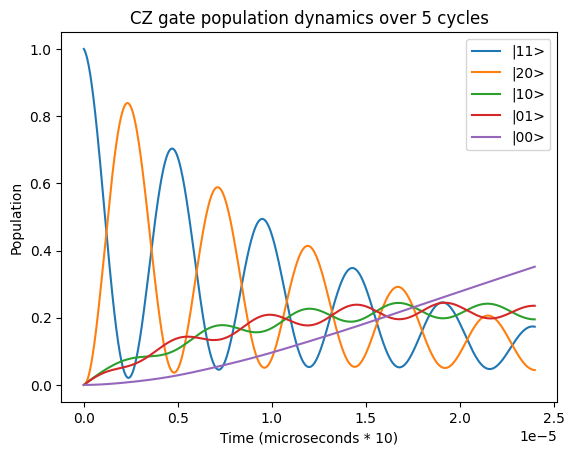

In [ ]:
dm_11 = tensor(basis(N,1)*basis(N,1).dag(),basis(N,1)*basis(N,1).dag()) #|11x11|
dm_20 = tensor(basis(N,2)*basis(N,2).dag(),basis(N,0)*basis(N,0).dag()) #|20x20|
dm_10 = tensor(basis(N,1)*basis(N,1).dag(),basis(N,0)*basis(N,0).dag()) #|10x10|
dm_01 = tensor(basis(N,0)*basis(N,0).dag(),basis(N,1)*basis(N,1).dag()) #|01x01|
dm_00 = tensor(basis(N,0)*basis(N,0).dag(),basis(N,0)*basis(N,0).dag()) #|00x00|
pop_11 = expect(dm_11, result.states)
pop_10 = expect(dm_10, result.states)
pop_01 = expect(dm_01, result.states)
pop_20 = expect(dm_20, result.states)
pop_00 = expect(dm_00, result.states)
plt.plot(times, pop_11, label='|11>')
plt.plot(times, pop_20, label='|20>')
plt.plot(times, pop_10, label='|10>')
plt.plot(times, pop_01, label='|01>')
plt.plot(times, pop_00, label='|00>')
plt.xlabel('Time (microseconds * 10)')
plt.ylabel('Population')
plt.legend()
plt.title('CZ gate population dynamics over 5 cycles')

Text(0.5, 1.0, 'iSWAP population dynamics over 5 cycles (initial state = |11>)')

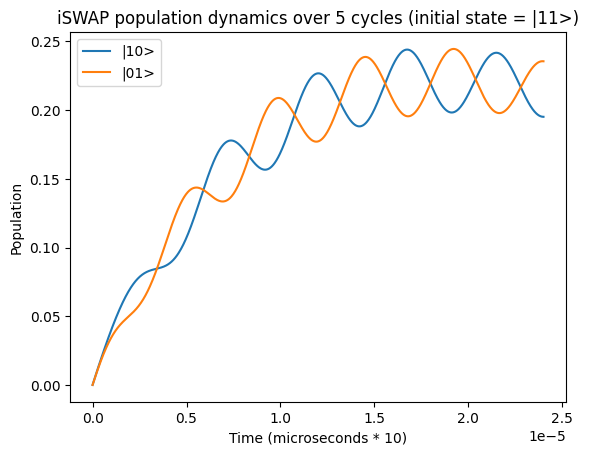

In [ ]:
plt.plot(times, pop_10, label='|10>')
plt.plot(times, pop_01, label='|01>')
plt.xlabel('Time (microseconds * 10)')
plt.ylabel('Population')
plt.legend()
plt.title('iSWAP population dynamics over 5 cycles (initial state = |11>)') ## do a simulation over cycles of iSWAP gate duration time